# Laue Image transform analysis

### on Lauetoolsenv : source /data/bm32/inhouse/lauetoolsenv/bin/activate
### Template matching + Resolving transformations 

#### Interesting reading blogs
##### https://matthew-brett.github.io/teaching/optimizing_space.html
##### https://learnopencv.com/image-alignment-ecc-in-opencv-c-python/

## Some useful functions

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2 as cv

def plot_img(img1, img2=None, img3=None, vmin=None, vmax=None, title1="", title2="", title3=""):
    if np.all(img3 == None) and np.all(img2 != None):
        fig, ax = plt.subplots(1,2)
    elif np.all(img2 == None) and np.all(img3 == None):
        fig, ax = plt.subplots()
    else:
        fig, ax = plt.subplots(1,3)
        
    if np.all(img2 == None) and np.all(img3 == None):
        ax.title.set_text(title1)
        if vmin!=None or vmax!=None:
            img000 = ax.imshow(img1, origin='lower', interpolation='None', vmin= vmin, vmax=vmax)
        else:
            img000 = ax.imshow(img1, origin='lower', interpolation='None')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(img000, cax=cax, orientation='vertical')
    else:
        ax[0].title.set_text(title1)
        if vmin!=None or vmax!=None:
            img000 = ax[0].imshow(img1, origin='lower', interpolation='None', vmin= vmin, vmax=vmax)
        else:
            img000 = ax[0].imshow(img1, origin='lower', interpolation='None')
        divider = make_axes_locatable(ax[0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(img000, cax=cax, orientation='vertical')

    if np.all(img2 != None):
        ax[1].title.set_text(title2)
        if vmin!=None or vmax!=None:
            img001 = ax[1].imshow(img2, origin='lower', interpolation='None', vmin= vmin, vmax=vmax)
        else:
            img001 = ax[1].imshow(img2, origin='lower', interpolation='None')
        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(img001, cax=cax, orientation='vertical')
    if np.all(img3 != None):
        ax[2].title.set_text(title3)
        if vmin!=None or vmax!=None:
            img002 = ax[2].imshow(img3, origin='lower', interpolation='None', vmin= vmin, vmax=vmax)
        else:
            img002 = ax[2].imshow(img3, origin='lower', interpolation='None')
        divider = make_axes_locatable(ax[2])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(img002, cax=cax, orientation='vertical')
    fig.tight_layout()
    plt.show()

## Read a Laue image and define a template

-- OK! You are using python 3


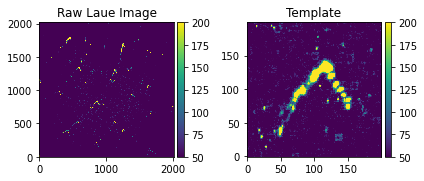

In [2]:
##better to do background correction on images to fix the background intensity (as at the center, we have diffusion)
laue_image_with_bg = plt.imread(r"Ni123_maps_1773.tif")
template_with_bg = np.copy(laue_image_with_bg[700:900,750:950])

from LaueTools import imageprocessing as ImProc
framedim = laue_image_with_bg.shape
CCDLabel = 'sCMOS'
backgroundimage = ImProc.compute_autobackground_image(laue_image_with_bg, boxsizefilter=10)
# basic substraction
laue_image = ImProc.computefilteredimage(laue_image_with_bg, backgroundimage, 
                                            CCDLabel, usemask=True, formulaexpression="A-B")
template = np.copy(laue_image[700:900,750:950])
#template = np.copy(laue_image[750:850,800:910])

plot_img(laue_image, template, vmin= 50, vmax=200, title1 = "Raw Laue Image", title2="Template")

### Skimage match_template routine

#### Provides all possible places in laue image where correlation with template is good

SKIMAGE peaksearch max XY 850 800


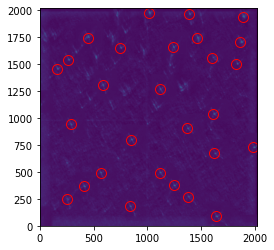

In [13]:
from skimage.feature import match_template
from skimage.feature import peak_local_max # new import!
result = match_template(laue_image, template, pad_input=True) #added the pad_input bool
## SKIMAGE PEAK SEARCH
##need to play with threshold_rel to find good number of peaks
peaks = peak_local_max(result, min_distance=20, threshold_rel=0.4) # find our peaks

print("SKIMAGE peaksearch max XY",peaks[0,1],peaks[0,0])
fig, ax = plt.subplots()
ax.imshow(result, origin="lower")
ax.plot(peaks[:,1], peaks[:,0], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.show()

28 7 4


/tmp/ipykernel_3915205/596863952.py:28: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.imshow(data, origin='lower', vmin=1000, vmax = 2000)


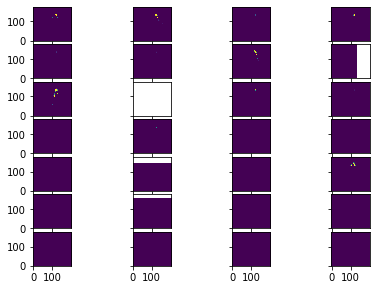

In [14]:
# Plot all locations of correlation peaks
list_idx_counters=range(len(peaks))
#-----------------------------------------
nbcounters = len(list_idx_counters)

# select displayed layout of plots
nbcols = 4
nrows=nbcounters//nbcols
if nbcounters%nbcols != 0:
    nrows +=1
    
if nbcounters<nrows*nbcols:
    list_idx_counters=list(list_idx_counters)
    list_idx_counters = list_idx_counters +['None'] * (nrows*nbcols - nbcounters)

print(nbcounters,nrows, nbcols)

fig2, axs = plt.subplots(ncols=nbcols, nrows=nrows, sharex=True, sharey=True)
missingplot=np.zeros_like(template)
ss = missingplot.shape

k=0
axsflat=axs.flat
for ax, _idx in zip(axsflat,list_idx_counters):
        if k<nbcounters:
            datax, datay = peaks[_idx]
            data = np.copy(laue_image[datax-template.shape[0]//2:datax+template.shape[0]//2,datay-template.shape[1]//2:datay+template.shape[1]//2])
            ax.imshow(data, origin='lower', vmin=1000, vmax = 2000)
        else:
            ax.imshow(missingplot, origin='lower')
        k+=1

plt.subplots_adjust(left=0.05,
                    bottom=0.05,
                    right=0.95,
                    top=0.95,
                    wspace=0.1,
                    hspace=0.1)

### Step 2

#### Once we have found the correlated regions, now we would like to get the transformation (DIC style) with respect to the template

warp_matrix [[  0.78715503  -0.12949935  42.88251   ]
 [  0.28867844   1.1111588  -49.668106  ]]


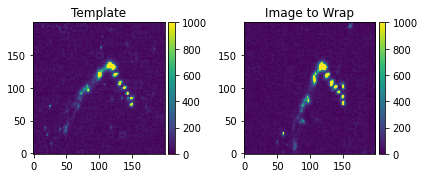

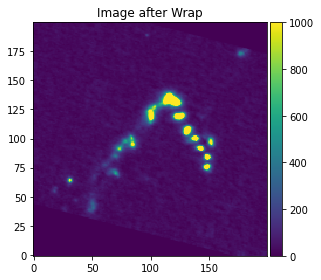

In [20]:
#In OpenCV 3, the motion model for ECC image alignment is estimated using the function findTransformECC . Here are the steps for using findTransformECC
#    Read the images.
#    Convert them to grayscale.
#    Pick a motion model you want to estimate.
#    Allocate space (warp_matrix) to store the motion model.
#    Define a termination criteria that tells the algorithm when to stop.
#    Estimate the warp matrix using findTransformECC.
#    Apply the warp matrix to one of the images to align it with the other image.

if __name__ == '__main__':  
    match_template_number = 1
    
    datax, datay = peaks[match_template_number]
    source = np.copy(laue_image[datax-template.shape[0]//2:datax+template.shape[0]//2,datay-template.shape[1]//2:datay+template.shape[1]//2])
    
    im1 = np.copy(template)
    im2 = np.copy(source)
    
    img1 = cv.normalize(im1, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
    img2 = cv.normalize(im2, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
    
    #plot_img(template, source)
    
    assert(img1.shape == img2.shape)
    # Find the width and height of the color image
    sz = img1.shape
    
    # Define motion model
    
    #Translation ( MOTION_TRANSLATION ) : The first image can be shifted ( translated ) by (x , y) to obtain the second image. 
    #There are only two parameters x and y that we need to estimate.
    
    #Euclidean ( MOTION_EUCLIDEAN ) : The first image is a rotated and shifted version of the second image. 
    #So there are three parameters — x, y and angle . You will notice in Figure 4, when a square undergoes 
    #Euclidean transformation, the size does not change, parallel lines remain parallel, and right angles 
    #remain unchanged after transformation.
    
    #Affine ( MOTION_AFFINE ) : An affine transform is a combination of rotation, translation ( shift ), scale, and shear. 
    #This transform has six parameters. When a square undergoes an Affine transformation, parallel lines remain parallel, 
    #but lines meeting at right angles no longer remain orthogonal.
    
    #Homography ( MOTION_HOMOGRAPHY ) : All the transforms described above are 2D transforms. 
    #They do not account for 3D effects. A homography transform on the other hand can account for some 3D effects 
    #( but not all ). This transform has 8 parameters. A square when transformed using a Homography can change 
    #to any quadrilateral.

    #In OpenCV an Affine transform is stored in a 2 x 3 sized matrix. 
    #Translation and Euclidean transforms are special cases of the Affine transform. 
    #In Translation, the rotation, scale and shear parameters are zero, 
    #while in a Euclidean transform the scale and shear parameters are zero. 
    #So Translation and Euclidean transforms are also stored in a 2 x 3 matrix. 
    #Once this matrix is estimated, the images can be brought into alignment using the function warpAffine.

    #Homography, on the other hand, is stored in a 3 x 3 matrix. Once the Homography is estimated, 
    #the images can be brought into alignment using warpPerspective.

    ## MOTION_EUCLIDEAN/ MOTION_AFFINE is more appropriate for us ?
    
    #warp_mode = cv.MOTION_TRANSLATION
    #warp_mode = cv.MOTION_EUCLIDEAN 
    warp_mode = cv.MOTION_AFFINE 
    #warp_mode = cv.MOTION_HOMOGRAPHY
    
    if warp_mode == cv.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)
    number_of_iterations = 5000
    termination_eps = 1e-10
    # Set the stopping criteria for the algorithm.
    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    
    (cc, warp_matrix) = cv.findTransformECC(img1, img2, warp_matrix, warp_mode, criteria)
    print("warp_matrix", warp_matrix)
    if warp_mode == cv.MOTION_HOMOGRAPHY :
        # Use warpPerspective for Homography
        im2_aligned = cv.warpPerspective(im2, warp_matrix, (sz[1],sz[0]), flags=cv.INTER_LINEAR + cv.WARP_INVERSE_MAP)
    else :
        # Use warpAffine for Translation, Euclidean and Affine
        im2_aligned = cv.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv.INTER_LINEAR + cv.WARP_INVERSE_MAP);
        
    # Show final results
    #plot_img(im1, im2, im2_aligned, title1="Template", title2="Image to Wrap", title3="Image after Wrap")
    plot_img(im1, im2, title1="Template", title2="Image to Wrap", vmax=1000)
    plot_img(im2_aligned, title1="Image after Wrap", vmax=1000)
    

In [27]:
##Meaning of Warp metrix: https://lubbil.ngontinh24.com/article/image-transformations-using-opencv-in-python-python-code

## Lets find features between the wrapped image and target image

Not enough matches are found - 4/5


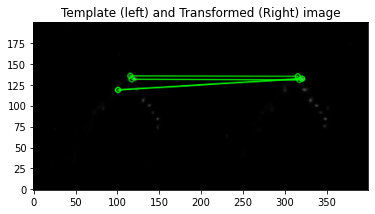

done


In [33]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img_1 = cv.normalize(template, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
img_2 = cv.normalize(im2_aligned, None, 0, 255, cv.NORM_MINMAX).astype('uint8')

# Initiate SIFT detector (SIFT accepts only 8bit images)
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img_1,None)
kp2, des2 = sift.detectAndCompute(img_2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
MIN_MATCH_COUNT = 5
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img_1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img_2 = cv.polylines(img_2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img_3 = cv.drawMatches(img_1, kp1, img_2, kp2, good, None, **draw_params)

fig, ax = plt.subplots()
ax.title.set_text("Template (left) and Transformed (Right) image")
ax.imshow(img_3, origin="lower", vmax=255//2) 
plt.show()
print("done")